In [344]:
import pandas as pd
import time
from math import log
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score,learning_curve, ShuffleSplit, StratifiedKFold, validation_curve, GridSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score, recall_score, f1_score, cohen_kappa_score,  confusion_matrix, classification_report, auc,roc_curve
from sklearn.utils import resample
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_roc_curve
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import GradientBoostingClassifier as GBC
import seaborn as sns
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
sns.set(color_codes=True)
%matplotlib inline
pd.set_option('display.max_columns', 30)
import warnings
warnings.filterwarnings("ignore")
import pgeocode
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import time

In [19]:
def plot_ROC_curve(y_pred, y_test, label='DNN', clr='orange', ls=':'):
    #y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    return roc_auc

In [325]:
len(df) * 0.1

1799.8000000000002

In [294]:
df = pd.read_csv(r"/Users/HanwenSun/Desktop/Emory MSBA/Travelers Competition/training_dataset.csv")
test = pd.read_csv(r"/Users/HanwenSun/Desktop/Emory MSBA/Travelers Competition/test_dataset.csv")
loc_info = pd.read_csv(r"/Users/HanwenSun/Desktop/Emory MSBA/Travelers Competition/Table_6_Offenses_Known_to_Law_Enforcement_by_State_by_City_2016-2.csv", thousands=',')
unemploy_info = pd.read_csv(r"/Users/HanwenSun/Desktop/Emory MSBA/Travelers Competition/unemployment.csv")
loc_info2 = pd.read_csv(r"/Users/HanwenSun/Desktop/Emory MSBA/Travelers Competition/zipcodeinfo.csv")

loc_info2 = loc_info2.fillna(0)
loc_info2['zip_code']=loc_info2['zip_code'].astype(int).astype(str)

loc_info = loc_info.rename(columns={"City": "place_name"})
loc_info = loc_info.drop_duplicates(subset=['place_name'])

crime_col = ['Violent_crime', 'Murder_and_nonnegligent_manslaughter', 'Rape', 'Robbery', \
       'Aggravated_assault', 'Property_crime', 'Burglary', 'Larceny_theft', \
       'Motor_vehicle_theft', 'Arson']

crime_rate = ['Violent_crime_rate', 'Murder_and_nonnegligent_manslaughter_rate', 'Rape_rate', 'Robbery_rate', \
       'Aggravated_assault_rate', 'Property_crime_rate', 'Burglary_rate', 'Larceny_theft_rate', \
       'Motor_vehicle_theft_rate', 'Arson_rate']


loc_info[crime_rate] = loc_info[crime_col].div(loc_info.Population, axis=0)

a = df['zip_code'].astype(str).tolist()
b = test['zip_code'].astype(str).tolist()

nomi = pgeocode.Nominatim('us')

a_zip = nomi.query_postal_code(a).loc[:,['postal_code','latitude','longitude','state_code','place_name']]
b_zip = nomi.query_postal_code(b).loc[:,['postal_code','latitude','longitude','state_code','place_name']]

df['zip_code'] = df['zip_code'].astype(str)
test['zip_code'] = test['zip_code'].astype(str)

df = pd.concat([df, a_zip], axis=1)
test = pd.concat([test, b_zip], axis=1)

#print(df.isna().sum())
#df = df.dropna()
#df = pd.concat([df, loc_info2], axis=1).reindex(df.index)
#test = pd.concat([test, loc_info2], axis=1).reindex(test.index)


#df = pd.merge(df, loc_info, left_on="place_name", right_on='place_name', how="left", sort=False)
#test = pd.merge(test, loc_info, left_on="place_name", right_on='place_name', how="left", sort=False)


df = pd.merge(df, loc_info2, left_on="zip_code", right_on='zip_code', how="left", sort=False)
test = pd.merge(test, loc_info2, left_on="zip_code", right_on='zip_code', how="left", sort=False)

df=df.drop(['zip_code','postal_code','place_name'], axis=1)
test=test.drop(['zip_code','postal_code','place_name'], axis=1)


#print(test.isna().sum())



#test = test.fillna(0)

#df[['marital_status','witness_present_ind','age_of_vehicle']]=df[['marital_status','witness_present_ind','age_of_vehicle']].astype(int)
#test[['marital_status','witness_present_ind','age_of_vehicle']]=test[['marital_status','witness_present_ind','age_of_vehicle']].astype(int)


X=df.drop(["fraud"], axis=1)

y=df["fraud"]
y=y.replace(-1, 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


X['claim_date']=pd.to_datetime(X["claim_date"])
X['claim_date'] = X['claim_date'].dt.to_period('M')
#X['month_year'] = X['month_year'].astype(str)

X_train['claim_date']=pd.to_datetime(X_train["claim_date"])
X_train['claim_date'] = X_train['claim_date'].dt.to_period('M')
#X_train['month_year'] = X_train['month_year'].astype(str)

X_test['claim_date']=pd.to_datetime(X_test["claim_date"])
X_test['claim_date'] = X_test['claim_date'].dt.to_period('M')
#X_test['month_year'] = X_test['month_year'].astype(str)

test['claim_date']=pd.to_datetime(test["claim_date"])
test['claim_date'] = test['claim_date'].dt.to_period('M')
#test['month_year'] = test['month_year'].astype(str)

unemploy_info['claim_date']=pd.to_datetime(unemploy_info["Year-Month"])
unemploy_info['claim_date'] = unemploy_info['claim_date'].dt.to_period('M')
#unemploy_info['month_year'] = unemploy_info['month_year'].astype(str)
unemploy_info=unemploy_info.drop(["Year-Month"], axis=1)

X = pd.merge(X, unemploy_info, left_on="claim_date", right_on='claim_date', how="left", sort=False)
X_train = pd.merge(X_train, unemploy_info, left_on="claim_date", right_on='claim_date', how="left", sort=False)
X_test = pd.merge(X_test, unemploy_info, left_on="claim_date", right_on='claim_date', how="left", sort=False)
test = pd.merge(test, unemploy_info, left_on="claim_date", right_on='claim_date', how="left", sort=False)

X["claim_income_percentage"]=X["claim_est_payout"] / X["annual_income"]
X["vehicle_income_percentage"]=X["vehicle_price"] / X["annual_income"]
X["vehicle_weight_percentage"]=X["vehicle_weight"] / X["vehicle_price"]
X['safety_rating_percentage']=X['safty_rating'] / (X['past_num_of_claims']+1)
X['housing_occupied_percentage']=X['occupied_housing_units']/X['housing_units']
#X['loc'] = X['latitude']/X['longitude']

X_train["claim_income_percentage"]=X_train["claim_est_payout"] / X_train["annual_income"]
X_train["vehicle_income_percentage"]=X_train["vehicle_price"] / X_train["annual_income"]
X_train["vehicle_weight_percentage"]=X_train["vehicle_weight"] / X_train["vehicle_price"]
X_train['safety_rating_percentage']=X_train['safty_rating'] / (X_train['past_num_of_claims'])
X_train['housing_occupied_percentage']=X_train['occupied_housing_units']/X_train['housing_units']
#X_train['loc'] = X_train['latitude']/X_train['longitude']

X_test["claim_income_percentage"]=X_test["claim_est_payout"] / X_test["annual_income"]
X_test["vehicle_income_percentage"]=X_test["vehicle_price"] / X_test["annual_income"]
X_test["vehicle_weight_percentage"]=X_test["vehicle_weight"] / X_test["vehicle_price"]
X_test['safety_rating_percentage']=X_test['safty_rating'] / (X_test['past_num_of_claims'])
X_test['housing_occupied_percentage']=X_test['occupied_housing_units']/X_test['housing_units']
#X_test['loc'] = X_test['latitude']/X_test['longitude']

test["claim_income_percentage"]=test["claim_est_payout"] / test["annual_income"]
test["vehicle_income_percentage"]=test["vehicle_price"] / test["annual_income"]
test["vehicle_weight_percentage"]=test["vehicle_weight"] / test["vehicle_price"]
test['safety_rating_percentage']=test['safty_rating'] / (test['past_num_of_claims'])
test['housing_occupied_percentage']=test['occupied_housing_units']/test['housing_units']
#test['loc'] = test['latitude']/test['longitude']

num_col = ['claim_est_payout','vehicle_price','vehicle_weight',"annual_income",\
           'claim_income_percentage','safety_rating_percentage','vehicle_weight_percentage',\
           'population_density', 'land_area_in_sqmi', 'water_area_in_sqmi', 'housing_units', \
           'median_household_income','housing_occupied_percentage','Unemployment']

#sqr_col = ['claim_est_payout_sqr','vehicle_price_sqr','vehicle_weight_sqr','claim_income_percentage_sqr',\
#          'vehicle_income_percentage_sqr','safety_rating_percentage_sqr',"annual_income_sqr",\
#          'vehicle_weight_percentage_sqr','radius_in_miles_sqr', 'population_density_sqr', 'land_area_in_sqmi_sqr', \
#           'water_area_in_sqmi_sqr', 'housing_units_sqr','occupied_housing_units_sqr', 'median_home_value_sqr', \
#           'median_household_income_sqr']

log_col = ['claim_est_payout_log','vehicle_price_log','vehicle_weight_log',\
           'claim_income_percentage_log','safety_rating_percentage_log','vehicle_weight_percentage_log',\
           "annual_income_log", 'population_density_log', \
           'land_area_in_sqmi_log', 'water_area_in_sqmi_log', 'housing_units_log', \
            'median_household_income_log','housing_occupied_percentage_log','Unemployment_log']


X_log = np.log(X[num_col])
X_train_log = np.log(X_train[num_col])
X_test_log = np.log(X_test[num_col])
test_log = np.log(test[num_col])

X_log = X_log.set_axis(log_col, axis=1, inplace=False)
X_train_log = X_train_log.set_axis(log_col, axis=1, inplace=False)
X_test_log = X_test_log.set_axis(log_col, axis=1, inplace=False)
test_log = test_log.set_axis(log_col, axis=1, inplace=False)

X = pd.concat([X, X_log], axis=1)
X_train = pd.concat([X_train, X_train_log], axis=1)
X_test = pd.concat([X_test, X_test_log], axis=1)
test = pd.concat([test, test_log], axis=1)

#X_sqr = X[num_col]**2
#X_train_sqr = X_train[num_col]**2
#X_test_sqr = X_test[num_col]**2
#test_sqr = test[num_col]**2

#X_sqr = X_sqr.set_axis(sqr_col, axis=1, inplace=False)
#X_train_sqr = X_train_sqr.set_axis(sqr_col, axis=1, inplace=False)
#X_test_sqr = X_test_sqr.set_axis(sqr_col, axis=1, inplace=False)
#test_sqr = test_sqr.set_axis(sqr_col, axis=1, inplace=False)

#X = pd.concat([X, X_sqr], axis=1)
#X_train = pd.concat([X_train, X_train_sqr], axis=1)
#X_test = pd.concat([X_test, X_test_sqr], axis=1)
#test = pd.concat([test, test_sqr], axis=1)

#car_size = {range(-1, 4000): 0, range(4000, 100000): 1}

#car_color = {'red':1, 'black':0,'silver':0,'white':0,'gray':0,'blue':0,'other':0,}

#car_size = {range(-1, 8000): 0, range(8000, 100000): 1}
#X['vehicle_category_2'] = X['vehicle_weight'].astype('int').replace(car_size)
#X_train['vehicle_category_2'] = X_train['vehicle_weight'].astype('int').replace(car_size)
#X_test['vehicle_category_2'] = X_test['vehicle_weight'].astype('int').replace(car_size)
#X_train['red_car'] = X_train['vehicle_color'].replace(car_color)
#test['vehicle_category_2'] = test['vehicle_weight'].astype('int').replace(car_size)


X['claim_date'] = X['claim_date'].dt.month.astype(str)
X_train['claim_date'] = X_train['claim_date'].dt.month.astype(str)
X_test['claim_date'] = X_test['claim_date'].dt.month.astype(str)
test['claim_date'] = test['claim_date'].dt.month.astype(str)

X=X.drop(["claim_date",'claim_day_of_week'], axis=1)
X_train=X_train.drop(["claim_date",'claim_day_of_week'], axis=1)
X_test=X_test.drop(["claim_date",'claim_day_of_week'], axis=1)
test=test.drop(["claim_date",'claim_day_of_week'], axis=1)

X=pd.get_dummies(X, drop_first=True)
X_train_1=pd.get_dummies(X_train, drop_first=True)
X_test_1=pd.get_dummies(X_test, drop_first=True)
test_1=pd.get_dummies(test, drop_first=True)

#X['f1_claim_weight'] = np.log(X.claim_est_payout**2 / X.vehicle_weight)
#X['f1_claim_weight'] = np.round(X['f1_claim_weight'], 1)
#X['f2_income_claims'] = np.round(X.annual_income / 1000)*10 + X.past_num_of_claims
#X['f3_accidents_claims'] = (X['accident_site_Parking Lot'] * 10) + (X.past_num_of_claims)
#X['f4_liab_income'] = np.round((X.liab_prct * np.round(X.annual_income,-2)), -4)
#X['f5_liab_price'] = np.round((X.liab_prct * np.round(X.vehicle_price,-2)), -4)
#X['f6_liab_price_safty'] = np.round((X.liab_prct * np.round(X.vehicle_price,-2)), -4) / X.safty_rating
#X['f7_claim_num_payout'] = (X.claim_number**3) * X.claim_est_payout
#X['f8_living_claims'] = (X.living_status_Rent + 1) * (X.past_num_of_claims + 1)
#X['f9_witness_payout'] = (X.witness_present_ind + 1) * (X.past_num_of_claims + 1) * np.round(X.claim_est_payout, -2)
#X['f10_interaction_f2_f3'] = np.sqrt((X.f2_income_claims + 1) * (X.f3_accidents_claims + 1))
#X['f11_education_claim'] = (X.claim_est_payout) / (X.high_education_ind + 1)
#X['f12_witness_f5'] = (X.witness_present_ind + 1) * np.log(X.f5_liab_price + 1)
#X['f13_matital_f2'] = np.round((X.marital_status + 1) * np.sqrt(X.f2_income_claims),1)


#test_1['f1_claim_weight'] = np.log(test_1.claim_est_payout**2 / test_1.vehicle_weight)
#test_1['f1_claim_weight'] = np.round(test_1['f1_claim_weight'], 1)
#test_1['f2_income_claims'] = np.round(test_1.annual_income / 1000)*10 + test_1.past_num_of_claims
#test_1['f3_accidents_claims'] = (test_1['accident_site_Parking Lot'] * 10) + (test_1.past_num_of_claims)
#test_1['f4_liab_income'] = np.round((test_1.liab_prct * np.round(test_1.annual_income,-2)), -4)
#test_1['f5_liab_price'] = np.round((test_1.liab_prct * np.round(test_1.vehicle_price,-2)), -4)
#test_1['f6_liab_price_safty'] = np.round((test_1.liab_prct * np.round(test_1.vehicle_price,-2)), -4) / test_1.safty_rating
#test_1['f7_claim_num_payout'] = (test_1.claim_number**3) * test_1.claim_est_payout
#test_1['f8_living_claims'] = (test_1.living_status_Rent + 1) * (test_1.past_num_of_claims + 1)
#test_1['f9_witness_payout'] = (test_1.witness_present_ind + 1) * (test_1.past_num_of_claims + 1) * np.round(test_1.claim_est_payout, -2)
#test_1['f10_interaction_f2_f3'] = np.sqrt((test_1.f2_income_claims + 1) * (test_1.f3_accidents_claims + 1))
#test_1['f11_education_claim'] = (test_1.claim_est_payout) / (test_1.high_education_ind + 1)
#test_1['f12_witness_f5'] = (test_1.witness_present_ind + 1) * np.log(test_1.f5_liab_price + 1)
#test_1['f13_matital_f2'] = np.round((test_1.marital_status + 1) * np.sqrt(test_1.f2_income_claims),1)

X.reset_index(drop=True, inplace=True)
X_train_1.reset_index(drop=True, inplace=True)
X_test_1.reset_index(drop=True, inplace=True)
test_1.reset_index(drop=True, inplace=True)

claim_number = test_1["claim_number"]

X=X.drop(["claim_number",'vehicle_income_percentage','median_home_value','occupied_housing_units','radius_in_miles'], axis=1)
X_train=X_train_1.drop(["claim_number",'vehicle_income_percentage','median_home_value','occupied_housing_units','radius_in_miles'], axis=1)
X_test=X_test_1.drop(["claim_number",'vehicle_income_percentage','median_home_value','occupied_housing_units','radius_in_miles'], axis=1)
test=test_1.drop(["claim_number",'vehicle_income_percentage','median_home_value','occupied_housing_units','radius_in_miles'], axis=1)

#df1 = X.copy()

#np.seterr(divide='ignore', invalid='ignore')
#scaler = StandardScaler()
#scaler.fit(X)
#data = scaler.transform(X)

#imputer = KNNImputer(n_neighbors=1, weights='distance')
#imputer.fit_transform(data)
#df1[:]= imputer.transform(data)
#df1[:]= scaler.inverse_transform(df1[:], copy=None)


#X_minority_upsampled = resample(df1[y==1], 
#                                  replace=True,                                         
#                                  n_samples=df1[y==0].shape[0],  
#                                  random_state=20)

#y_minority_upsampled = resample(y[y==1], 
#                                  replace=True,                                         
#                                  n_samples=df1[y==0].shape[0],  
#                                  random_state=20)

#X=pd.concat([df1[y==0], X_minority_upsampled])
#y=pd.concat([y[y==0], y_minority_upsampled])

In [98]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd. DataFrame (fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.sort_values(by=['Score'], ascending = False)


,Specs,Score
19,housing_units,29320.428918
16,population_density,13795.514388
13,vehicle_weight,10068.531405
3,annual_income,8813.913495
10,claim_est_payout,4705.814218
24,safety_rating_percentage,2207.531805
22,claim_income_percentage,2153.529149
20,median_household_income,462.358119
6,past_num_of_claims,459.064911
0,age_of_driver,208.096947


In [401]:
featureScores.rename(columns={"Specs": "Feature Name", "Score": "Chi-Squared Feature Importance"}).sort_values(by=['Chi-Squared Feature Importance'], ascending = False)

,Feature Name,Chi-Squared Feature Importance
19,housing_units,29320.428918
16,population_density,13795.514388
13,vehicle_weight,10068.531405
3,annual_income,8813.913495
10,claim_est_payout,4705.814218
24,safety_rating_percentage,2207.531805
22,claim_income_percentage,2153.529149
20,median_household_income,462.358119
6,past_num_of_claims,459.064911
0,age_of_driver,208.096947


In [327]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17998 entries, 0 to 17997
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age_of_driver                    17998 non-null  int64  
 1   marital_status                   17993 non-null  float64
 2   safty_rating                     17998 non-null  int64  
 3   annual_income                    17998 non-null  int64  
 4   high_education_ind               17998 non-null  int64  
 5   address_change_ind               17998 non-null  int64  
 6   past_num_of_claims               17998 non-null  int64  
 7   witness_present_ind              17866 non-null  float64
 8   liab_prct                        17998 non-null  int64  
 9   policy_report_filed_ind          17998 non-null  int64  
 10  claim_est_payout                 17981 non-null  float64
 11  age_of_vehicle                   17990 non-null  float64
 12  vehicle_price     

In [341]:
inner_cv = KFold(n_splits=5,shuffle=True,random_state = 12)

gs_xgb = RandomizedSearchCV(estimator=xgb.XGBClassifier(),
                  param_distributions=[{"max_depth": [2,3,4],
                               "min_child_weight" : [1,3,6,10],
                               "n_estimators": [200,300,500],
                               'reg_lambda': [0.2,0.3,0.5],
                               'gamma': [0.2,0.3,0.4],
                               'num_parallel_tree': [1],
                               'reg_alpha': [0, 0.1, 0.2],
                               "learning_rate": [0.02,0.03,0.04],
                               'colsample_bytree': [0.8,0.9],
                               'min_child_weight': [10,5],
                               'eval_metric': ['auc']}],
                  scoring='roc_auc',
                  n_iter=15,
                  cv=inner_cv,
                  n_jobs=4, verbose = 2)


gs_xgb = gs_xgb.fit(X,y)

print("Non-nested CV Accuracy: ", gs_xgb.best_score_)
print("Optimal Parameter: ", gs_xgb.best_params_)
print("Optimal Estimator: ", gs_xgb.best_estimator_)
print()

plt.figure(figsize=(10,6)) 
plt.plot(np.arange(1,16,1),gs_xgb.cv_results_['mean_test_score'], color='blue', marker='o', ls='-.')


plt.grid(alpha=0.8)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Number of Trials')
plt.ylabel('AUC')
plt.title('XGBoost Random Search')

AttributeError: 'numpy.ndarray' object has no attribute 'XGBClassifier'

Text(0.5, 1.0, 'XGBoost Random Search')

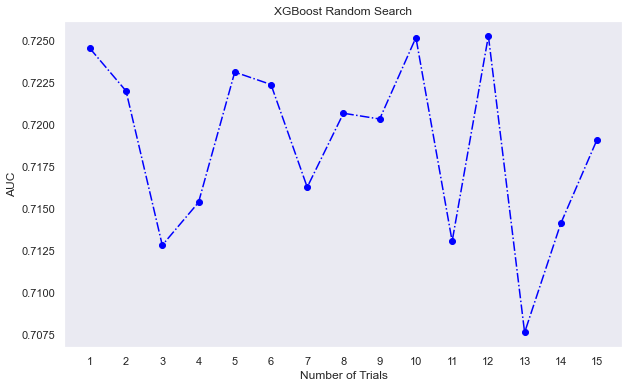

In [213]:
plt.figure(figsize=(10,6)) 
plt.plot(np.arange(1,16,1),gs_xgb.cv_results_['mean_test_score'], color='blue', marker='o', ls='-.')


plt.grid(alpha=0.8)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Number of Trials')
plt.ylabel('AUC')
plt.title('XGBoost Random Search')

Nested CV AUC: 0.7252912223614547  +/-  0.0046481199696913516


Text(0.5, 1.0, '5-Fold Performance Comparison')

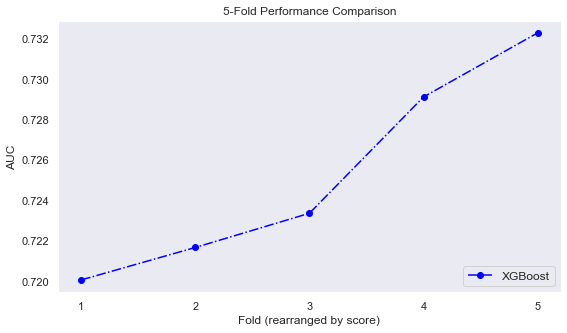

In [343]:
#clf_xgb = xgb.XGBClassifier(max_depth=2,min_child_weight=10,n_estimators=200,learning_rate=0.01,eval_metric='auc',\
#                            reg_lambda=0.5, reg_alpha=0.3,subsample=0.8,gamma=0.3,use_label_encoder =False)

#clf_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
#              gamma=0.3, gpu_id=-1, importance_type='gain',
#              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
#              max_depth=2, min_child_weight=5,
#              monotone_constraints='()', n_estimators=500, n_jobs=4,
#              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=0.3,
#              scale_pos_weight=1, subsample=1, tree_method='exact',
#              validate_parameters=1, verbosity=None)

clf_xgb = gs_xgb.best_estimator_

# 10 fold precision comparison
plt.figure(figsize=(9,5)) 
outer_cv = KFold(n_splits=5, shuffle=True,random_state = 12)
nested_score_clf_xgb = cross_val_score(clf_xgb, X=X, y=y, cv=outer_cv, scoring='roc_auc')
print("Nested CV AUC:",nested_score_clf_xgb.mean(), " +/- ", nested_score_clf_xgb.std())
nested_score_clf_xgb.sort()

plt.plot(np.arange(1,6,1),nested_score_clf_xgb, color='blue', label='XGBoost', marker='o', ls='-.')

plt.legend(loc='lower right',fontsize=12)    # Where to place the legend

plt.grid(alpha=0.8)
plt.xlabel('Fold (rearranged by score)')
plt.xticks([1,2,3,4,5])
plt.ylabel('AUC')
plt.title('5-Fold Performance Comparison')

In [399]:
# Feature importance

#lightGBM model fit
gbm = lgbm.LGBMClassifier()
gbm.fit(X, y)
gbm.booster_.feature_importance()

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols':X.columns, 'fea_imp':gbm.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 100].sort_values(by=['fea_imp'], ascending = False)

,cols,fea_imp
24,safety_rating_percentage,185
10,claim_est_payout,168
13,vehicle_weight,162
8,liab_prct,161
12,vehicle_price,151
15,longitude,150
2,safty_rating,138
3,annual_income,132
11,age_of_vehicle,127
25,housing_occupied_percentage,124


In [51]:
#Recursive Feature Elimination(RFE)
rfe = RFE(gbm, 5)
rfe = rfe.fit(df1, y)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols':df1.columns, 'fea_rank':rfe.ranking_})
fea_1 = fea_rank_.loc[fea_rank_.fea_rank == 1].sort_values(by=['fea_rank'], ascending = True)
fea_1['cols']

3                 annual_income
10             claim_est_payout
12                vehicle_price
23    vehicle_weight_percentage
24     safety_rating_percentage
Name: cols, dtype: object

In [406]:
def lgbm_cv_evaluator(learning_rate, num_leaves, reg_lambda, feature_fraction, bagging_fraction, max_depth):
    # Setup Parameters
    params = {  'boosting_type':        'gbdt',
                'num_iterations':       1500, 
                'early_stopping_round': 100, 
                'metric':               'auc',
                'verbose':              -1,
                'drop_rate': 0.1,
                'subsample': 0.9,
                'is_unbalance': True,
                #'min_child_sample': 10,
                'min_child_weight': 150,
                'min_split_gain': 0
            }
    params['learning_rate'] =       learning_rate
    params['num_leaves'] =          int(round(num_leaves))
    params['reg_lambda'] =          reg_lambda
    params['feature_fraction'] =    feature_fraction
    params['bagging_fraction'] =    bagging_fraction
    params['max_depth'] =           int(round(max_depth))
        
    # Run LightGBM Cross Validation
    result = lgbm.cv(params, lgbm_dataset, nfold= 5, seed = 12, num_boost_round=10000,\
                     stratified = True, verbose_eval = -1, metrics = ['auc']) 
    
    # Return AUC
    return max(result['auc-mean'])



In [407]:
def bayesian_parameter_optimization(init_rounds = 1, opt_rounds = 1):    
    
    # Initialize Bayesian Optimization
    optimizer = BayesianOptimization(f = lgbm_cv_evaluator, 
                                    pbounds = { 'learning_rate':        (0.01, 0.045),
                                                'num_leaves':           (3, 3),
                                                'reg_lambda':           (3, 3.5),
                                                'feature_fraction':     (0.2, 0.7),
                                                'bagging_fraction':     (0.55, 0.95),
                                                'max_depth':            (6, 60)
                                              },
                                    verbose = 2)
    # Perform Bayesian Optimization. 
    # Modify acq, kappa and xi to change the behaviour of Bayesian Optimization itself.
    optimizer.maximize(init_points = init_rounds, n_iter = opt_rounds, acq = "ei", kappa = 2, xi = 0.1)
    
    # Return Found Best Parameter values and Target
    return optimizer.max

In [408]:
lgbm_dataset = lgbm.Dataset(data = X, label = y)

max_params = bayesian_parameter_optimization(init_rounds = 15, opt_rounds = 15)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | num_le... | reg_la... |
-------------------------------------------------------------------------------------------------
|  1        |  0.728    |  0.9252   |  0.6534   |  0.02029  |  47.67    |  3.0      |  3.317    |
|  2        |  0.7278   |  0.7946   |  0.6354   |  0.0215   |  7.493    |  3.0      |  3.463    |
|  3        |  0.728    |  0.9032   |  0.5508   |  0.02746  |  35.56    |  3.0      |  3.137    |
|  4        |  0.7277   |  0.846    |  0.6787   |  0.02494  |  18.25    |  3.0      |  3.153    |
|  5        |  0.7278   |  0.6588   |  0.407    |  0.04133  |  48.86    |  3.0      |  3.271    |
|  6        |  0.7281   |  0.5579   |  0.2591   |  0.03666  |  26.47    |  3.0      |  3.463    |
|  7        |  0.7278   |  0.6466   |  0.2045   |  0.03578  |  9.592    |  3.0      |  3.238    |
|  8        |  0.7279   |  0.676    |  0.5693   |  0.03382  |  43.76    |  3.0      |  3.284    |
|  9        |  0.727

Text(0.5, 1.0, 'LightGBM Hyperparameter Tuning')

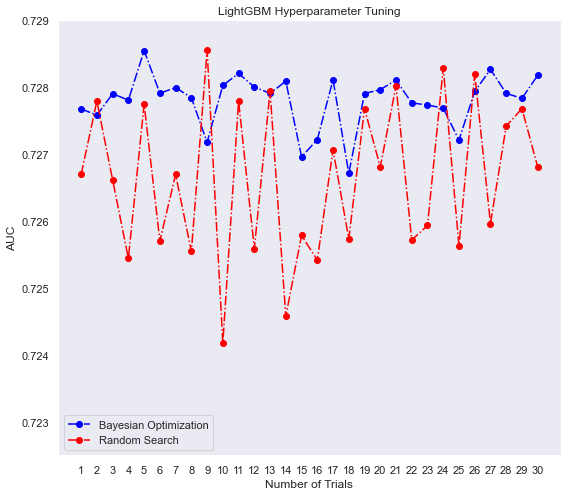

In [292]:
plt.figure(figsize=(9,8)) 
plt.plot(np.arange(1,31,1),pd.DataFrame(data=max_params)['target'],label='Bayesian Optimization', color='blue', marker='o', ls='-.')
plt.plot(np.arange(1,31,1),gs_lgbm.cv_results_['mean_test_score'],label='Random Search', color='red', marker='o', ls='-.')


plt.grid(alpha=0.8)
plt.legend(loc='lower left')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
plt.xlabel('Number of Trials')
plt.ylabel('AUC')
plt.ylim([0.7225, 0.729])
plt.title('LightGBM Hyperparameter Tuning')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Non-nested CV Accuracy:  0.7285575065125547
Optimal Parameter:  {'reg_lambda': 3.4000000000000004, 'num_leaves': 3, 'max_depth': 45, 'learning_rate': 0.015, 'feature_fraction': 0.2, 'bagging_fraction': 0.9000000000000004}
Optimal Estimator:  LGBMClassifier(bagging_fraction=0.9000000000000004, drop_rate=0.1,
               feature_fraction=0.2, is_unbalance=True, learning_rate=0.015,
               max_depth=45, metric='auc', min_child_weight=150,
               min_split_gain=0, num_iterations=1500, num_leaves=3,
               reg_lambda=3.4000000000000004, subsample=0.9, verbose=-1)



Text(0.5, 1.0, 'LightGBM Random Search')

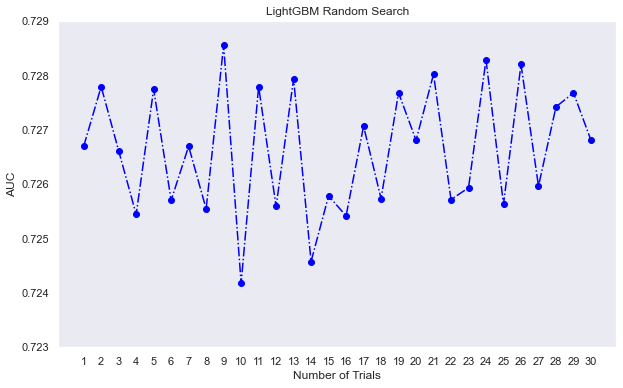

In [287]:
inner_cv = KFold(n_splits=5,shuffle=True,random_state = 12)

gs_lgbm = RandomizedSearchCV(estimator=lgbm.LGBMClassifier(boosting_type = 'gbdt',
                num_iterations = 1500,
                metric = 'auc',
                verbose = -1,
                drop_rate = 0.1,
                subsample = 0.9,
                is_unbalance = True,
                min_child_weight = 150,
                min_split_gain = 0),
                param_distributions=[{'F':    list(np.arange(0.01, 0.045,0.005))  ,
                                        'num_leaves':       (3, 3),
                                        'reg_lambda':    list(np.arange(3, 3.5,0.1))   ,
                                        'feature_fraction': list(np.arange(0.2, 0.7,0.1))    ,
                                        'bagging_fraction':  list(np.arange(0.55, 0.95,0.05))  ,
                                        'max_depth':    list(np.arange(6,60,1))}],
                  scoring='roc_auc',
                  n_iter=30,
                  cv=inner_cv,
                  n_jobs=4, verbose = 2)


gs_lgbm = gs_lgbm.fit(X,y)

print("Non-nested CV Accuracy: ", gs_lgbm.best_score_)
print("Optimal Parameter: ", gs_lgbm.best_params_)
print("Optimal Estimator: ", gs_lgbm.best_estimator_)
print()

plt.figure(figsize=(10,6)) 
plt.plot(np.arange(1,31,1),gs_lgbm.cv_results_['mean_test_score'], color='blue', marker='o', ls='-.')


plt.grid(alpha=0.8)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
plt.xlabel('Number of Trials')
plt.ylabel('AUC')
plt.ylim([0.723, 0.729])
plt.title('LightGBM Random Search')

Text(0.5, 1.0, 'LightGBM Random Search')

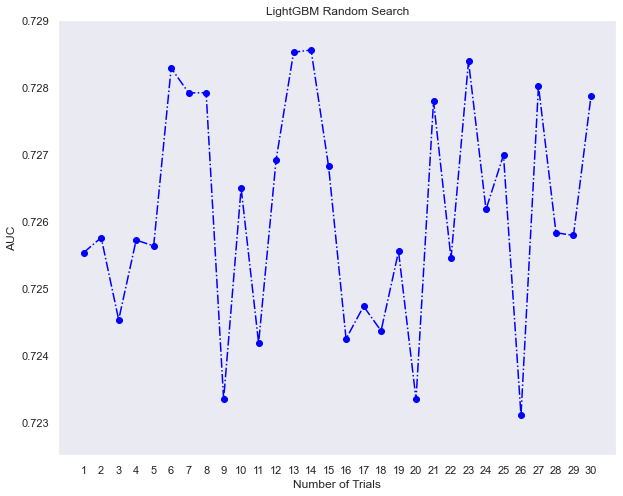

In [271]:
plt.figure(figsize=(10,8)) 


plt.grid(alpha=0.8)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
plt.xlabel('Number of Trials')
plt.ylabel('AUC')
plt.ylim([0.7225, 0.729])
plt.title('LightGBM Random Search')

[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is

Text(0.5, 1.0, '5-Fold Cross Validation (Random State = 12)')

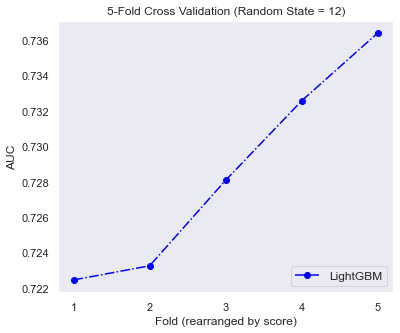

In [314]:
params = max_params.get('params')
params['learning_rate'] =       params['learning_rate']
params['num_leaves'] =          int(round(params['num_leaves']))
params['feature_fraction'] =    params['feature_fraction']
params['bagging_fraction'] =    params['bagging_fraction']
params['max_depth'] =           int(round(params['max_depth']))
params['reg_lambda'] =          params['reg_lambda']


clf_lgbm = lgbm.LGBMClassifier(
                boosting_type=        'gbdt',
                num_iterations=       2000, 
                metric=               'auc',
                verbose=              -1,
                drop_rate= 0.1,
                subsample= 0.9,
                is_unbalance= True,
                min_child_weight= 150,
                min_split_gain= 0,
                learning_rate=params['learning_rate'],
                num_leaves=params['num_leaves'],
                feature_fraction=params['feature_fraction'],
                bagging_fraction=params['bagging_fraction'],
                max_depth=params['max_depth'],
                reg_lambda=params['reg_lambda'])


# 5 fold precision comparison
plt.figure(figsize=(8,10)) 
outer_cv = KFold(n_splits=5, shuffle=True,random_state = 12)
nested_score_clf_lgbm = cross_val_score(gs_lgbm.best_estimator_, X=X, y=y, cv=outer_cv, scoring='roc_auc')
print("Nested CV AUC:",nested_score_clf_lgbm.mean(), " +/- ", nested_score_clf_lgbm.std())
nested_score_clf_lgbm.sort()

plt.plot(np.arange(1,6,1),nested_score_clf_lgbm, color='blue', label='LightGBM', marker='o', ls='-.')

plt.legend(loc='lower right',fontsize=12)    # Where to place the legend

plt.grid(alpha=0.8)
plt.xlabel('Fold (rearranged by score)')
plt.xticks([1,2,3,4,5])
plt.ylabel('AUC')
plt.title('5-Fold Cross Validation (Random State = 12)')

[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is

Text(0.5, 1.0, '5-Fold Cross Validation (Random State = 12)')

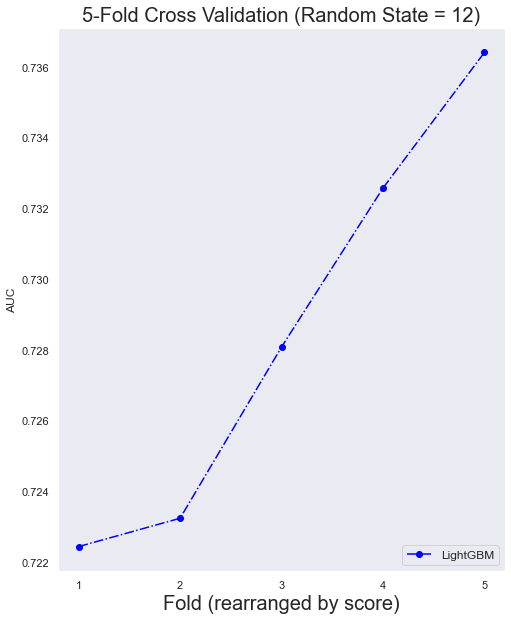

In [415]:
plt.figure(figsize=(8,10)) 
outer_cv = KFold(n_splits=5, shuffle=True,random_state = 12)
nested_score_clf_lgbm = cross_val_score(gs_lgbm.best_estimator_, X=X, y=y, cv=outer_cv, scoring='roc_auc')
print("Nested CV AUC:",nested_score_clf_lgbm.mean(), " +/- ", nested_score_clf_lgbm.std())
nested_score_clf_lgbm.sort()

plt.plot(np.arange(1,6,1),nested_score_clf_lgbm, color='blue', label='LightGBM', marker='o', ls='-.')

plt.legend(loc='lower right',fontsize=12)    # Where to place the legend

plt.grid(alpha=0.8)
plt.xlabel('Fold (rearranged by score)',fontsize=20)
plt.xticks([1,2,3,4,5])
plt.ylabel('AUC')
plt.title('5-Fold Cross Validation (Random State = 12)',fontsize=20)

Text(0.5, 1.0, '5-Fold Cross Validation')

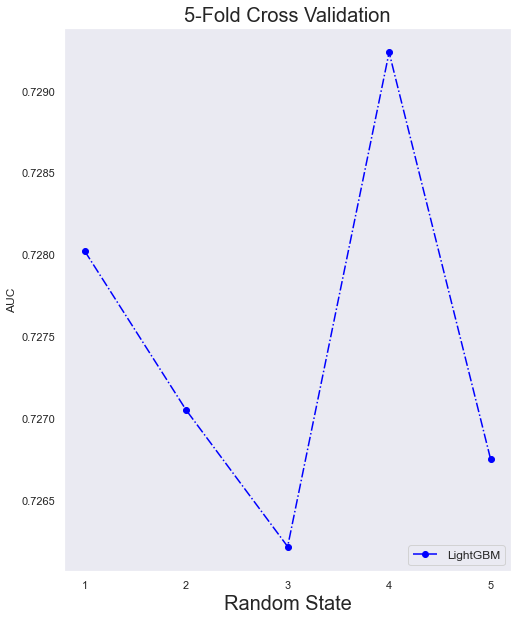

In [414]:
plt.figure(figsize=(8,10))
plt.plot(np.arange(1,6,1),a, color='blue', label='LightGBM', marker='o', ls='-.')

plt.legend(loc='lower right',fontsize=12)    # Where to place the legend

plt.grid(alpha=0.8)
plt.xlabel('Random State',fontsize=20)
plt.xticks([1,2,3,4,5])
plt.ylabel('AUC',fontsize=12)
plt.title('5-Fold Cross Validation',fontsize=20)

In [394]:
start_time = time.time()

a = []

for i in range(5):
    outer_cv = KFold(n_splits = 5, shuffle = True,random_state = i)
    nested_score_clf_lgbm = cross_val_score(gs_lgbm.best_estimator_, X=X, y=y, cv=outer_cv, scoring='roc_auc')
    a.append(nested_score_clf_lgbm.mean())
    print(i)
    
print("--- %s seconds ---" % (time.time() - start_time))

[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000004, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9000000000000004
[LightGBM] [Warning] feature_fraction is

Text(0.5, 1.0, 'Repeated 100-time 5-Fold Cross Validation')

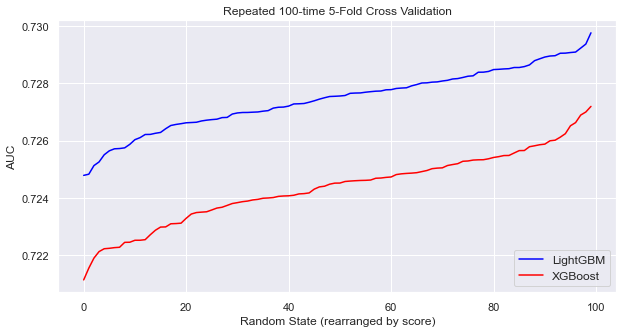

In [384]:
plt.figure(figsize=(10,5))
plt.plot(lgbm_100, color='blue', label='LightGBM')
plt.plot(xgb_100, color='red', label='XGBoost')

plt.legend(loc='lower right',fontsize=12)  
plt.xlabel('Random State (rearranged by score)')
plt.ylabel('AUC')
plt.title('Repeated 100-time 5-Fold Cross Validation')

In [391]:
pd.DataFrame(lgbm_100).mean()

0    0.727453
dtype: float64

In [158]:
inner_cv = KFold(n_splits = 5, shuffle = True,random_state = 42)

from sklearn.tree import DecisionTreeClassifier

dt0 = DecisionTreeClassifier(random_state=42)
dt = cross_val_score(dt0,X = df1,y = y,cv=inner_cv, scoring='roc_auc')

from sklearn.linear_model import LogisticRegression 
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

lr0 = LogisticRegression(random_state=42)
lr = cross_val_score(lr0,X = df1,y = y,cv=inner_cv, scoring='roc_auc')

from sklearn.ensemble import RandomForestClassifier
rf0 = RandomForestClassifier(random_state=42)
rf = cross_val_score(rf0,X = df1,y = y,cv=inner_cv, scoring='roc_auc')

lgb0 = lgbm.LGBMClassifier(random_state=42)
lgb = cross_val_score(lgb0,X = df1,y = y,cv=inner_cv, scoring='roc_auc')

In [362]:
lgbm_100 = lgbm_100[0:100]

In [349]:
start_time = time.time()

xgb_100 = []
for i in range(100):
    outer_cv = KFold(n_splits = 5, shuffle = True,random_state = i)
    nested_score_clf_xgb = cross_val_score(clf_xgb, X=X, y=y, cv=outer_cv, scoring='roc_auc')
    lgbm_100.append(nested_score_clf_xgb.mean())
    print(i)
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
--- 1224.0078909397125 seconds ---


Text(0.5, 1.0, 'Algorithm Performance')

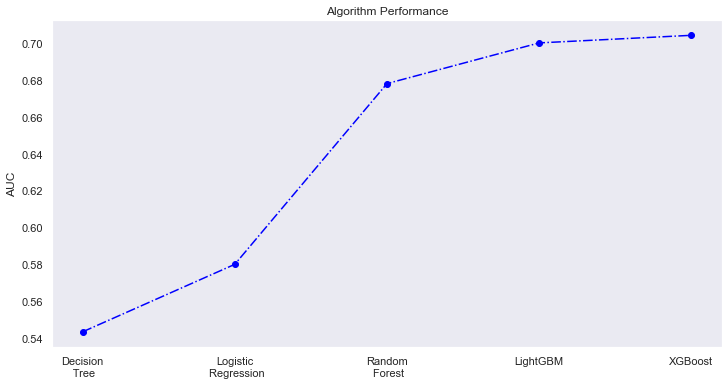

In [275]:
plt.figure(figsize=(12,6)) 
plt.plot(np.arange(1,6,1),a, color='blue', marker='o', ls='-.')

x = np.array([1,2,3,4,5])
myticks = ['Decision\n Tree','Logistic\n Regression', 'Random\n Forest', 'LightGBM', 'XGBoost']
plt.grid(alpha=0.8)
plt.xticks(x, myticks)
plt.ylabel('AUC')
plt.title('Algorithm Performance')